In [1]:
import sys
from os import path

if __package__ is None:
    #print("__package__ is None") 
    print(path.dirname( path.dirname( path.abspath('__file__') ) ))
    sys.path.append(path.dirname( path.dirname( path.abspath("__file__") ) ))
from Jutils import display_video

import mujoco_py
import copy
import os
import itertools
from IPython.display import clear_output, display, Image, HTML
import numpy as np
# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import PIL.Image

/home/jskang/center/Examples_Mujoco


# Example codes for Camera Setting in Gym Robotics 

In [3]:
# Setting camera distance, angles
def set_cam(env, config) :

    pos = config['pos']
    env.viewer.cam.distance = config['distance']
    env.viewer.cam.azimuth = config['azimuth'] # angle for horizontal
    env.viewer.cam.elevation = config['elevation'] # angle for vertical
    #env.viewer.move_camera(pos[0],pos[1],pos[2]) # move_camera에 들어가는 (?,?,?) parameter가 각각 뭘 뜻하는지 모르겠음. 주의할점 : 0이나 음수 값 넣으면 무한루프돌음

# Setting camera pos : env.move_camera


Createing Video..


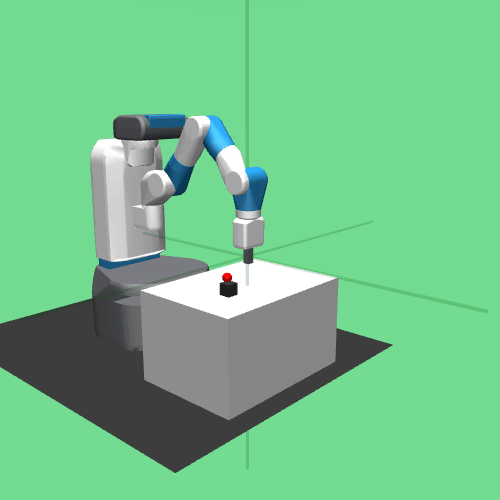

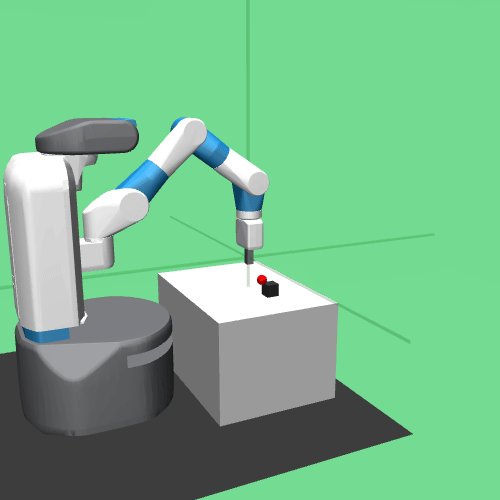

In [5]:
import gym
env_name = 'FetchPickAndPlace-v1'
env = gym.make(env_name) # Initalize with 'Humanoid-v3' - embedded in Gym
env.reset()

cam_config_1 = {'pos' : (1,1,1), 'distance' : 2.5, 'azimuth' : 132.0, 'elevation' : -14.0}
cam_config_2 = {'pos' : (1,1,1), 'distance' : 2.5, 'azimuth' : 64.0, 'elevation' : -14.0}

video_1 = []
video_2 = []
env.render(mode='rgb_array')
for _ in range(10):
    obs, reward, done, info = env.step(env.action_space.sample()) # take a random action
    pixels = env.render(mode='rgb_array')
    set_cam(env, cam_config_1)
    video_1.append(env.render(mode='rgb_array').copy())
    set_cam(env, cam_config_2)
    video_2.append(env.render(mode='rgb_array').copy())

env.close()
print("Createing Video..")
display_video(video_1, gif=True)
display_video(video_2, gif=True)

# Call to implementation : 

하나의 장면에 대해 여러 각도의 화면을 한 Video로 만드는 함수.

여러개의 화면을 수평 방향 일렬로 붙이거나, Grid 형태의 2X2 형태로 만들거나.



In [ ]:
'''
env : env
cam_configs : configs for different angle
shape : ? X ? 모양으로 만들것인지. 
'''

def render_multi_angle(env, cam_configs, shape) :

    return # pixel


# Use Example
import gym
env = gym.make(env_name) 
env.reset()

cam_config_1 = {'distance' : 2.5, 'azimuth' : 132.0, 'elevation' : -14.0}
cam_config_2 = {'distance' : 2.5, 'azimuth' : 62.0, 'elevation' : -14.0}
cam_configs = [cam_config_1, cam_config_2]


video = [] # 
env.render(mode='rgb_array')
#env.viewer.move_camera()
for _ in range(10):
    obs, reward, done, info = env.step(env.action_space.sample()) # take a random action
    pixels = render_multi_angle(env, cam_configs)
    video.append(pixels)

display_video(video, gif=True)



추가 요청사항 :
1. render 하는 화면의 Width, Height를 조정할 수 있는지. 가능하다면 이것도 별개의 세팅으로 다뤄야할듯

## Unused codes

In [ ]:
def get_rand_action(n_action, lower_bounds = None, upper_bounds = None) :
    _ = np.random.uniform(low=lower_bounds, high=upper_bounds, size=n_action)
    return _


import gym
env = gym.make('Humanoid-v3') # Initalize with 'Humanoid-v3' - embedded in Gym
env.reset()
num_action = np.array(env.action_space.shape).sum()
#get_rand_action(bounds=num_action)
_ = get_rand_action(num_action, lower_bounds=np.zeros(num_action), upper_bounds = np.ones(num_action))
print(_)

[0.44643207 0.89642285 0.54069876 0.05261    0.53876308 0.58694733
 0.57269913 0.19629916 0.20814226 0.32408057 0.98974142 0.24232614
 0.34310946 0.59581271 0.13379268 0.72506118 0.0668755 ]


In [ ]:
!jupyter nbextension enable --py widgetsnbextension
from ipywidgets import *


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
